# Random forest estimator

In [5]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import regex as re


import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance


## Loading the dataset
The dataset is divided in files depending on the CE efficiency $ \alpha $ and the metallicity $ Z $ of the two stars. All the data are loaded into a pandas dataframe containing also the two parameters.


In [6]:

alpha = [0.5, 1, 3, 5] # CE efficiency
Z = [2e-4, 4e-4, 8e-4, 1.2e-3, 1.6e-3, 2e-3, 4e-3, 6e-3, 8e-3, 1.2e-2, 1.6e-2, 2e-2]  #Metallicity value

data = [] #Data list 

sim_data = pd.DataFrame({'alpha':[], 'Z':[], 'MtotZAMS':[], 'num_mergers':[]})
#Appending all the values in a single big dataframe

index = 0
for a in alpha:
  for m in Z:
    # The simulation data first row contains the MtotZAMS and the number of merger for each alpha and metallicity 
    df = pd.read_csv(f'stable_MT_vs_CE/A{a}/MTCE_BBHs_{m}.txt', sep=' ', nrows = 1, header=0) 
    sim_data.loc[index] = [a, m, df.iloc[0,0], df.iloc[0,1]]  #Adding the row to the sim_data df
    index = index + 1 

    df = pd.read_csv(f'stable_MT_vs_CE/A{a}/MTCE_BBHs_{m}.txt', header=2, sep= ' ')     # Simulation data
    df['alpha'],df['Z'] = a, m                                 #Adding the alpha and Z paramtere in the table
    
    data.append(df)

data = pd.concat(data)
# Cleaning the column names using regex: sub substitutes with '' all strings that matches the first regex
# that starts from col, has any (.) char repeated any times (*) until :, and (|) from / any char, any times to the end of line $
data.columns = [re.sub('col.*:|/.*$', '', name) for name in data.columns]
print('Data columns: \n ', data.columns.values)


Data columns: 
  ['ID' 'm1ZAMS' 'm2ZAMS' 'm1rem' 'm2rem' 'm1rem+m2rem' 'delay_time' 'sma'
 'ecc' 'kick' 'kick' 'cmu1' 'cmu2' 'v1x' 'v1y' 'v1z' 'v2x' 'v2y' 'v2z'
 'time_SN1' 'time_SN2' 'CE' 'alpha' 'Z']


In [7]:
CE_data = data.query('CE == True')
MT_data = data.query('CE == False')


print(f'There are {CE_data.shape[0]} BBHs evolving from common envelope, and {MT_data.shape[0]} BBHs evolving from mass transfer')


There are 2551001 BBHs evolving from common envelope, and 412581 BBHs evolving from mass transfer


In [8]:
data_to_ML = data.copy()

x = data_to_ML[['m1ZAMS', 'm2ZAMS','m1rem','m2rem','delay_time','sma']]
#x = data.drop(columns=['ID', 'CE'])
y = data_to_ML['CE']

# split data into training and test set
# for now: 10% of data as training set
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.9, random_state=100)


In [9]:
# initialise random forest classifier
# using n_jobs=-1 saves quite a bit of time (~80s with vs ~430s without)
clf = RandomForestClassifier(random_state=0, n_jobs=-1)

# train random forest
# let's time this for fun
ts = time.time()
clf.fit(X_train, y_train)
print("Training time: %.2f s"%(time.time()-ts))

# evaluate training & test accuracy
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)


Training time: 34.45 s
Training accuracy:  1.0
Test accuracy:  0.9971273503837698


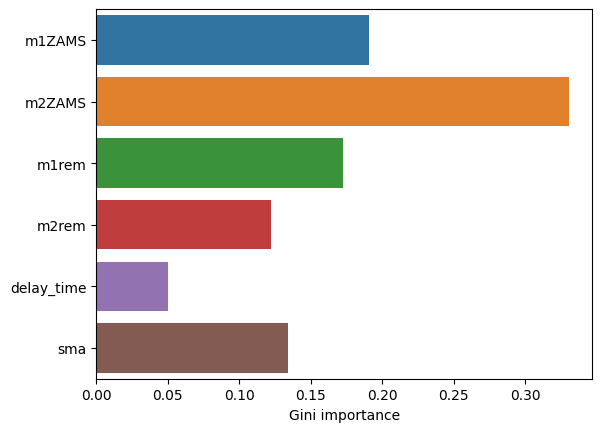

In [10]:
# save params + importances to dataframe
importances = pd.DataFrame(zip(clf.feature_names_in_, clf.feature_importances_),
                           columns=["param", "gini"])

# sort importances
#importances = importances.sort_values(by="gini", ascending= False)

# plot importances
fig, ax = plt.subplots()
sns.barplot(y='param', x='gini', data=importances, ax=ax)
#ax.tick_params(axis='x', rotation=90) #for params on x and gini on y
ax.set_ylabel('')
ax.set_xlabel('Gini importance')
plt.show()
